## Задача

Обучите простую рекуррентную нейронную сеть (без GRU/LSTM, без внимания) решать задачу дешифровки шифра Цезаря:
1. Написать алгоритм шифра Цезаря для генерации выборки (сдвиг на N каждой буквы). Например если N=2, то буква A переходит в букву C. Можно поиграться с языком на выбор (немецкий, русский и т.д.)
2. Создать архитектуру рекуррентной нейронной сети.
3. Обучить ее (вход - зашифрованная фраза, выход - дешифрованная фраза).
4. Проверить качество модели.

## Решение

In [1]:
import torch
import torch.nn as nn

import time
import numpy as np

import matplotlib.pyplot as plt

Зададим генераторы случайных чисел и тензоров

In [2]:
rng = np.random.default_rng(seed=31)
torch.manual_seed(31)

Зададим алфавит

In [3]:
rus_alphabet = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'

Создадим класс CaesarEncoder, который позволяет на основе заданного алфавита создать алфавит со смещением, а также словарь преобразования букв в цифры следующего вида {буква алфавита : порядковый номер буквы} (этот словарь необходим для преобразования последовательности букв в незашифрованной фразе в последовательность цифр для последующего формирования зашифрованной фразы) и словарь преобразования цифр в букву следующего вида {порядковый номер буквы : буква алфавита} (этот словарь необходим для преобразования последовательности цифр, полученных для фразы, в последовательность букв). 

In [4]:
class CaesarEncoder(nn.Module):
    """Класс для шифрования текста с помощью шифра Цезаря с функцией сдвига"""

    def __init__(self, alphabet):
        """Инициализирует класс CaesarEncoder со случайным сдвигом.

        Аргументы:
            alphabet (list): Алфавит, который используется для шифрования.
        """
        super().__init__()
        self.alphabet = alphabet
        self.shift = rng.integers(1, len(alphabet))

    def shift_alphabet(self, alphabet, shift):
        """Сдвигает алфавит на заданное количество позиций.

        Аргументы:
            alphabet (list): Алфавит, который используется для шифрования.
            shift (int): Случайное значение сдвига для шифра Цезаря.

        Возвращает:
            tuple: Кортеж из двух списков:
                - Исходный алфавит.
                - Алфавит, сдвинутый на указанное количество позиций.
        """
        x = [alphabet[i] for i in range(len(alphabet))]
        y = [
            alphabet[len(alphabet) - shift + i] if i < shift else alphabet[i - shift]
            for i in range(len(alphabet))
        ]
        return x, y

    def letter_to_index(self, alphabet):
        """Создает словарь, который сопоставляет каждой букве алфавита ее индекс.

        Аргументы:
            alphabet (list): Алфавит, который используется для шифрования.

        Возвращает:
            dict: Словарь, где ключ — это буква, а значение — ее индекс.
                  Также включает ключи "none" (значение 0) и пробел (значение 1).
        """
        return {w: i for i, w in enumerate(["none"] + [" "] + alphabet)}

    def index_to_letter(self, alphabet):
        """Создает словарь, который сопоставляет каждому индексу соответствующую букву алфавита.

        Аргументы:
            alphabet (list): Алфавит для создания отображения.

        Возвращает:
            dict: Словарь, где ключ — это индекс, а значение — буква.
                  Также включает значения "none" (ключ 0) и пробел (ключ 1).
        """
        return {i: w for i, w in enumerate(["none"] + [" "] + alphabet)}


Создадим экземпляр класса CaesarEncoder, задав в качестве аргумента русский алфавит rus_alphabet:

In [5]:
caesar_encoder = CaesarEncoder(rus_alphabet)

Создадим исходный алфавит и алфавит со сдвигом в форме списков.

In [6]:
shift = caesar_encoder.shift
original_alphabet, shifted_alphabet = caesar_encoder.shift_alphabet(rus_alphabet, shift)
original_alphabet[0:5], shifted_alphabet[0:5]

(['а', 'б', 'в', 'г', 'д'], ['о', 'п', 'р', 'с', 'т'])

Сформируем словарь вида "буква : порядковый номер" для преобразования исходного алфавита. В данном словаре первые значения 0 и 1 присвоены "none" и пробелу, поэтому букве "а" присвоен порядковый номер 2.

In [7]:
letter_to_index_original = caesar_encoder.letter_to_index(original_alphabet)
letter_to_index_original["а"]

2

Создадим словари вида "порядковый номер буквы : буква" для преобразования исходного алфавита и алфавита со сдвигом

In [8]:
index_to_letter_original = caesar_encoder.index_to_letter(original_alphabet)
index_to_letter_shifted = caesar_encoder.index_to_letter(shifted_alphabet)

Приведем несколько крылатых выражений, приписываемых Юлию Цезарю, в качестве фраз, которые будут служить в качестве обучающей выборки для модели.

In [9]:
train_original_phrases = [
    "пришёл увидел победил",
    "люди охотно верят тому чему желают верить",
    "никакая победа не принесет столько сколько может отнять одно поражение",
    "величайший враг спрячется там где вы будете меньше всего искать",
    "никто не отважен настолько чтобы не испугаться неожиданного",
    "правителя не так легко столкнуть с первого места на второе как потом со второго на последнее",
    "великие дела надо совершать не раздумывая чтобы мысль об опасности не ослабляла отвагу и быстроту",
    "лучше сразу умереть нежели жить ожиданием смерти",
    "победители и влюбленные не болеют",
    "не теряет лишь тот кто ничего не имеет",
    "ццццццццццц",
    "ээээээээээээ",
    "щщщщщщщщщщщщ"
]

Зашифруем данные фразы с учетом выбранного значения сдвига shift:

In [10]:
def encrypt(phrases: list) -> list:
    """Функция шифрования текста.

    Аргументы:
        phrases (list): Список фраз на оригинальном языке.

    Возвращает:
        list: Список зашифрованных фраз в виде списка списков.
    """
    return [
        [index_to_letter_shifted[letter_to_index_original[j]] for j in i] for i in phrases
    ]

Представим зашифрованные фразы

In [11]:
for phrase in encrypt(train_original_phrases):
    letters = ""
    for letter in phrase:
        letters += letter
    print(letters)

юячжфъ врчтуъ юэпутчъ
ъмтч эдэбьэ руянб бэыв ёуыв хуъомб руячбк
ьчщощон юэпуто ьу юячьуауб абэъкщэ ащэъкщэ ыэхуб эбьнбк этьэ юэяохуьчу
руъчёошжчш ряос аюянёубан боы сту рй пвтубу ыуькжу раусэ чащобк
ьчщбэ ьу эброхуь ьоабэъкщэ ёбэпй ьу чаювсобкан ьуэхчтоььэсэ
юяорчбуън ьу бощ ъусщэ абэъщьвбк а юуярэсэ ыуабо ьо рбэяэу щощ юэбэы аэ рбэяэсэ ьо юэаъутьуу
руъчщчу туъо ьотэ аэруяжобк ьу яоцтвыйрон ёбэпй ыйаък эп эюоаьэабч ьу эаъопънъо эбросв ч пйабяэбв
ъвёжу аяоцв выуяубк ьухуъч хчбк эхчтоьчуы аыуябч
юэпутчбуъч ч ръмпъуььйу ьу пэъумб
ьу буянуб ъчжк бэб щбэ ьчёусэ ьу чыууб
еееееееееее
лллллллллллл
зззззззззззз


### 2. Создание архитектуры рекуррентной нейронной сети

Создадим тензоры для зашифрованных фраз (Х) и оригинальных фраз (y). Данные тензоры будут использоваться для обучения модели и оценки ее качества. Эти тензоры будут созданы как нулевые тензоры, размер которых определяется длиной фразы, но не более максимального значения (максимальная длина фразы, равная 100 символам; если длина фразы будет превышать данное значение, то избыточная часть фразы будет удалена). Это обеспечивает одинаковый размер всех тензоров (соответствует максимальной длине фразы). Каждой букве в фразе с помощью словаря letter_to_index_original будет присвоен соответствующий номер.

In [12]:
max_phrase_length = 100

X = torch.zeros((len(encrypt(train_original_phrases)), max_phrase_length), dtype=torch.long)
for i in range(len(encrypt(train_original_phrases))):
    for j, w in enumerate(encrypt(train_original_phrases)[i]):
        if j >= max_phrase_length:
            break
        X[i, j] = letter_to_index_original.get(w, letter_to_index_original["none"])

y = torch.zeros((len(train_original_phrases), max_phrase_length), dtype=torch.long)
for i in range(len(train_original_phrases)):
    for j, w in enumerate(train_original_phrases[i]):
        if j >= max_phrase_length:
            break
        y[i, j] = letter_to_index_original.get(w, letter_to_index_original["none"])

Создадим модель рекуррентной нейронной сети на основе nn.Module. Данная модель будет включать несколько слоев. Первый слой - слой создания векторов, каждый из которых будет кодировать букву (вернее, ее порядковый номер) с помощью 30 параметров. Второй слой - сама рекуррентная нейронная сеть, имеющая 256 скрытых состояний. Кроме того, присутствуют несколько слоев Dropout, которые "выключают", т.е. обнуляют 20 % узлов, а также несколько слоев функции активации ReLU. Последний слой - линейный слой, который получает на вход 128 состояний и отдает тензор, размер которого равен размеру словаря.

In [13]:
class NetworkRNN(nn.Module):
    """Реализация сети RNN для обработки последовательностей.

    Атрибуты:
        embed (nn.Embedding): Слой для преобразования входных данных в векторы фиксированной размерности.
        rnn (nn.RNN): Слой RNN для обработки последовательностей.
        relu1 (nn.ReLU): Функция активации ReLU.
        dropout1 (nn.Dropout): Слой Dropout для регуляризации.
        linear1 (nn.Linear): Линейный слой для преобразования выходных данных.
        relu2 (nn.ReLU): Функция активации ReLU.
        dropout2 (nn.Dropout): Слой Dropout для регуляризации.
        linear2 (nn.Linear): Линейный слой для получения окончательных предсказаний.
    """

    def __init__(self):
        """Инициализирует все слои сети."""
        super().__init__()
        self.embed = nn.Embedding(len(letter_to_index_original), 30)
        self.rnn = nn.RNN(30, 256, batch_first=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(256, 128)
        self.output = nn.Linear(128, len(letter_to_index_original))

    def forward(self, text, state=None):
        """Прямой проход через модель.

        Аргументы:
            text (Tensor): Входной текст в виде тензора.
            state (Tensor, optional): Состояние RNN, если оно доступно.

        Возвращает:
            tuple: Выход сети и состояние RNN.
        """
        embed = self.embed(text)
        out, state = self.rnn(embed, state)
        out = self.linear(self.dropout(self.relu(out)))
        output = self.output(self.dropout(self.relu(out)))
        return output, state

### 3. Обучение модели

Создадим экземпляр модели нейронной сети. В качестве функции loss будем использовать CrossEntropyLoss, а в качестве оптимизатора - оптимизатор Adam при learning rate = 0,001.

In [14]:
def initialize_model(lr=0.001):
    """
    Инициализирует модель с указанным рекуррентным слоем (RNN, LSTM или GRU), 
    функцией потерь и оптимизатором.

    Параметры
    ----------
    lr : float, optional
        Значение скорости обучения модели.

    Возвращает
    ---------
    model : torch.nn.Module
        Инициализированная модель.
    criterion : torch.nn.Module
        Функция потерь (кросс-энтропия).
    optimizer : torch.optim.Optimizer
        Оптимизатор Adam.
    """

    model = NetworkRNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    return model, criterion, optimizer

In [15]:
model, criterion, optimizer = initialize_model()

Создадим функцию для обучения модели, которая будет принимать на вход модель, оптимизатор, функцию loss, а также тензоры Х и y. Функция будет возвращать накопленное усредненное значение функции loss. В данной функции для каждой фразы, применяемой для обучения, используем только ненулевые значения, чтобы снизить шум. Поскольку text_len представляет собой одномерный тензор, а функция forward (как функция модели RNN) ожидает двумерный тензор, добавим размерность с помощью функции unsqueeze(0), после чего преобразуем размерность тензора с помощью функции view в соответствии с размером словаря, поскольку мы хотим получить значения вероятности для соответствующих букв в словаре.

In [16]:
def train_loss(model, optimizer, criterion, x, y):
    model.train()
    total_loss = 0
    for i in range(len(x)):
        optimizer.zero_grad()
        
        text_len = (x[i] != letter_to_index_original["none"]).sum().item()
        
        answers, _ = model.forward(x[i][:text_len].unsqueeze(0), state=None)
        answers = answers.view(-1, len(letter_to_index_original))
        
        loss = criterion(answers, y[i][:text_len].flatten())
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    return total_loss / len(x)

Создадим функцию для управления процессом обучения и визуализации изменения функции потерь в зависимости от количества эпох обучения

In [17]:
def train_loss_control(model, optimizer, criterion, x, y, n_epochs=50):
    """
    Управляет процессом обучения модели, отслеживает значения функции потерь и выводит их график.

    Параметры
    ---------
    model : torch.nn.Module
        Модель, которая будет обучаться.
    optimizer : torch.optim.Optimizer
        Оптимизатор для обновления весов модели.
    criterion : torch.nn.Module
        Функция потерь для оптимизации.
    X : torch.Tensor
        Входные данные для обучения.
    y : torch.Tensor
        Целевые метки для обучения.
    n_epochs : int, optional
        Количество эпох обучения (по умолчанию 50).

    Возвращает
    ----------
    list
        Список значений функции потерь на каждой эпохе.
    """
    loss_values = []
    for epoch in range(n_epochs):
        start = time.time()
        train_loss_value = train_loss(model, optimizer, criterion, x, y)
        loss_values.append(train_loss_value)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}. Time: {time.time() - start:.3f}, Train loss: {train_loss_value:.3f}")

    plt.plot(loss_values)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Training Loss over Epochs: {model.rnn}")
    plt.show()

    return loss_values

Проведем обучение модели на 50 эпохах и визуализируем снижение значения loss с увеличением эпох

Epoch 0. Time: 0.266, Train loss: 3.492
Epoch 10. Time: 0.127, Train loss: 0.197
Epoch 20. Time: 0.124, Train loss: 0.028
Epoch 30. Time: 0.121, Train loss: 0.012
Epoch 40. Time: 0.123, Train loss: 0.006


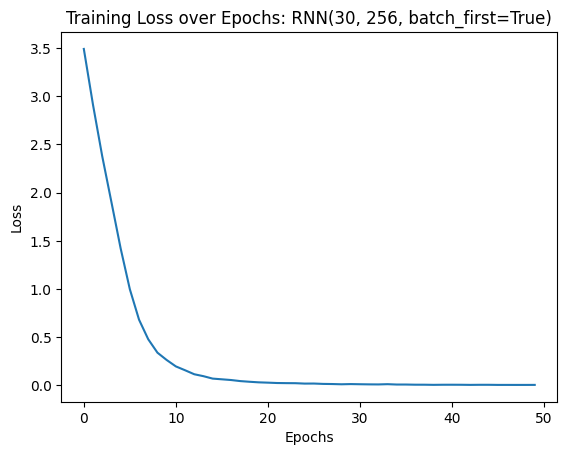

In [18]:
loss_values = train_loss_control(model, optimizer, criterion, X, y, n_epochs=50)

### 4. Оценка качества предсказаний, выполненных с помощью модели

Создадим функцию, которая будет расшифровывать фразу, созданную с помощью шифра Юлия Цезаря. Эта функция принимает на вход зашифрованную фразу, расшифрованную фразу (для оценки точности дешифровки), словари для преобразования буквы в индекс и обратно индекса в букву, а также значение максимальной длины фразы.

In [19]:
def decrypt(model, encrypted_phrase, original_phrase, letter_to_index, index_to_letter, max_phrase_length=100):
    """
    Функция для дешифровки текста с помощью обученной модели.
    
    model: обученная модель.
    encrypted_phrase: зашифрованная фраза.
    original_phrase: исходная фраза.
    letter_to_index: словарь для преобразования символов в индексы.
    index_to_letter: словарь для преобразования индексов в символы.
    max_phrase_length: максимальная длина фразы (должна быть равна длине зашифрованного текста).
    """
    # Преобразуем зашифрованный текст в индексы
    X = torch.zeros((1, max_phrase_length), dtype=int)
    for i, char in enumerate(encrypted_phrase):
        if i >= max_phrase_length:
            break
        X[0, i] = letter_to_index.get(char, letter_to_index["none"])

    model.eval()
    with torch.no_grad():
        output, _ = model(X)

        predicted_phrase = []
        correct = 0
        total = len(original_phrase)

        for i in range(output.size(1)):
            predicted_index = output[0, i].argmax().item()
            predicted_char = index_to_letter.get(predicted_index, "none")
            predicted_phrase.append(predicted_char)

            correct += (predicted_char == original_phrase[i])
        accuracy = correct / total * 100

    print(f"\nAccuracy: {round(accuracy, 2)} %")
    print(f"Original phrase: {original_phrase}")

    return ''.join(predicted_phrase).strip()

Отберем несколько фраз, приписываемых Юлию Цезарю, которые будут служить в качестве контрольных фраз.

In [20]:
test_original_phrases = [
                         "лучше быть первым в провинции чем вторым в риме",
                         "сегодня эта победа осталась бы за противниками если бы у них было кому победить",
                         "власть только выигрывает и усиливается оттого когда ею пользуются умеренно"
                         ]

Зашифруем эти фразы с помощью шифра Юлия Цезаря для получения контрольных зашифрованных фраз

In [21]:
for phrase in encrypt(test_original_phrases):
    letters = ""
    for letter in phrase:
        letters += letter
    print(letters)

ъвёжу пйбк юуярйы р юяэрчьечч ёуы рбэяйы р ячыу
аусэтьн лбо юэпуто эабоъоак пй цо юяэбчрьчщоыч уаъч пй в ьчд пйъэ щэыв юэпутчбк
ръоабк бэъкщэ рйчсяйроуб ч вачъчроубан эббэсэ щэсто ум юэъкцвмбан выуяуььэ


Используя созданную функцию дешифровки, преобразуем созданные зашифрованные фразы в исходные контрольные фразы.

In [22]:
for i, j in zip(encrypt(test_original_phrases), test_original_phrases):
    decrypted_phrase = decrypt(model, i, j, letter_to_index_original, index_to_letter_original, max_phrase_length=len(i))
    print(f"Decrypted phrase: {decrypted_phrase}\n")


Accuracy: 100.0 %
Original phrase: лучше быть первым в провинции чем вторым в риме
Decrypted phrase: лучше быть первым в провинции чем вторым в риме


Accuracy: 100.0 %
Original phrase: сегодня эта победа осталась бы за противниками если бы у них было кому победить
Decrypted phrase: сегодня эта победа осталась бы за противниками если бы у них было кому победить


Accuracy: 100.0 %
Original phrase: власть только выигрывает и усиливается оттого когда ею пользуются умеренно
Decrypted phrase: власть только выигрывает и усиливается оттого когда ею пользуются умеренно



## Заключение

Созданная модель на основе RNN демонстрирует отличные результаты. Достоверность предсказаний равна 100 %. Однако на предшествующих этапах тестирования качества созданной модели было обнаружено, что модель допускает ошибки в отдельных буквах (э, ц, щ) (точность предсказания фраз составляла менее 100 %). Было выдвинуто предположение о том, что эти ошибки не были связаны с нелинейностью сдвига алфавита (для тех букв, которые из конца алфавита переносятся в его начало, величина сдвига увеличивается на 2, поскольку в начале алфавита добавляются "none" и пробел), поскольку другие буквы, находящиеся рядом с ними (например, я, ы и др.), предсказывались моделью хорошо. Была выдвинута гипотеза о том, что проблема заключается в недостаточной обученности модели в отношении этих букв. Именно поэтому в набор фраз для обучения (train_original_phrases) были добавлены строки с буквами "э", "ц" и "щ". Это дало результат: качество предсказания модели достигло 100 %. Проблема была устранена.